# Stochastic simulations for Dynamic IDM (i.e., AR+IDM) and Memory-Augmented (MA)-IDM (i.e., GP+IDM)

In this notebook, we are mainly comparing the simulation results between the hierachicle AR+IDM (dynamic IDM, with different orders) V.S. GP+IDM (MA-IDM).

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pickle
import os
import sys
import numpy as np
import scipy
import CRPS.CRPS as pscore

sys.path.append('../')
from data.data_loader import read_training_data
from config import Config

## Car-following scenario illustration

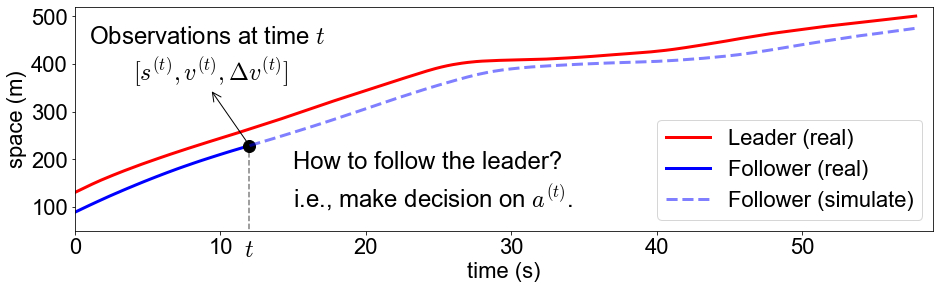

In [6]:
# plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

base_path = '../data/highD/'
tracks = read_training_data(base_path=base_path, min_traj_lenth=50 * Config.frame_rate_orignial)

figure, ax1 = plt.subplots(figsize=(13, 4))
pair_id = Config.car_interactive_pair_list[0]
x = tracks[pair_id]['xFollReal'] + 500
x_leader = tracks[pair_id]['xLeaderReal'] +500
dt = Config.dt
T = dt * np.array([range(x.shape[0])]).transpose()

plt.plot(T,x_leader+5,'-r', label='Leader (real)', linewidth=3)
plt.plot(T[:60],x[:60],'-b', label='Follower (real)', linewidth=3)
plt.plot(T[60],x[60],'ok', markersize=12)
plt.plot(T[60:],x[60:],'--', color='b', label='Follower (simulate)',alpha=0.5, linewidth=3)
plt.plot([T[60],T[60]],[3,x[60]], '--k', alpha=0.5)

plt.xlim(0,59)
plt.ylim(50,520)
plt.xlabel('time (s)',fontsize=22)
plt.ylabel('space (m)',fontsize=22)
plt.legend(loc='lower right',fontsize=22)

ax1.annotate(" ",
             xy=(12, x[60]), xycoords='data',
             xytext=(9, x[60]+110), textcoords='data',
             arrowprops=dict(arrowstyle="<-", color="k",
                             shrinkA=5, shrinkB=5,
                             patchA=None, patchB=None,
#                              connectionstyle="angle3,angleA=-37,angleB=6",
                             ),
             )
ax1.text(x=1, y=x[60]+215, s='Observations at time $t$', fontsize=24, color='k')
ax1.text(x=4, y=x[60]+137, s='$[s^{(t)},v^{(t)},\Delta v^{(t)}]$', fontsize=24, color='k')

ax1.text(x=15, y=180, s='How to follow the leader?', fontsize=24, color='k')
ax1.text(x=15, y=100, s='i.e., make decision on $a^{(t)}$.', fontsize=24, color='k')
ax1.text(x=11.6, y=-5, s='$t$', fontsize=24, color='k')

plt.tight_layout(rect=(-0.02, -0.08, 1.02, 1.04))
plt.show()
# figure.savefig('../Figs/CF_data_sim.pdf', dpi=300)

## Non-i.i.d. residuals

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


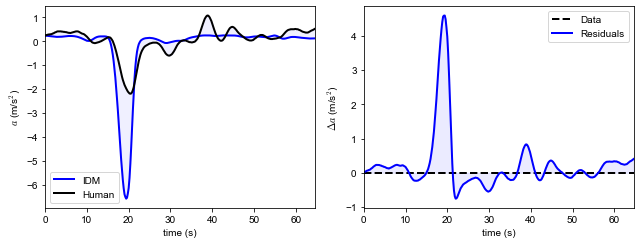

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


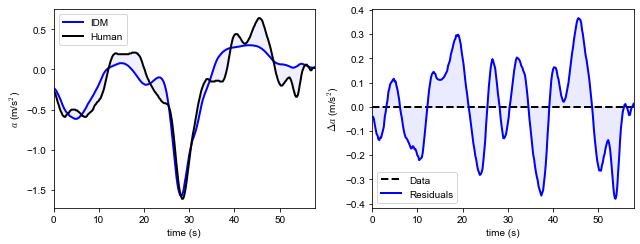

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


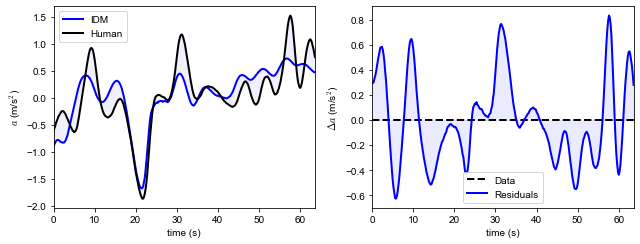

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


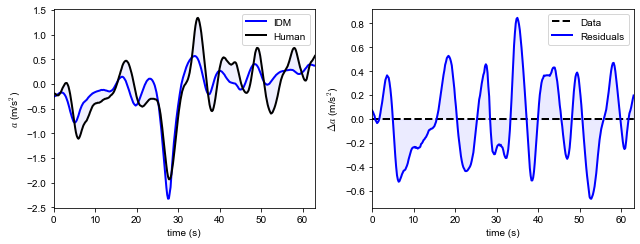

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


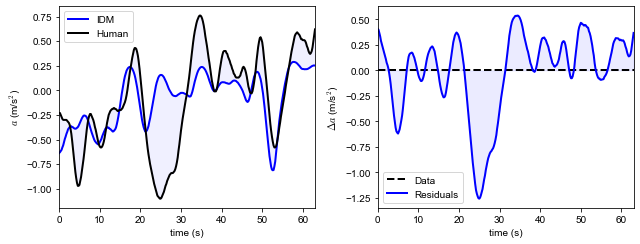

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


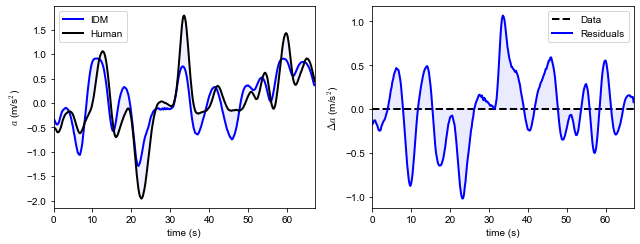

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


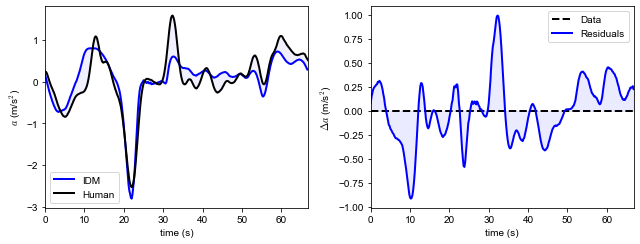

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


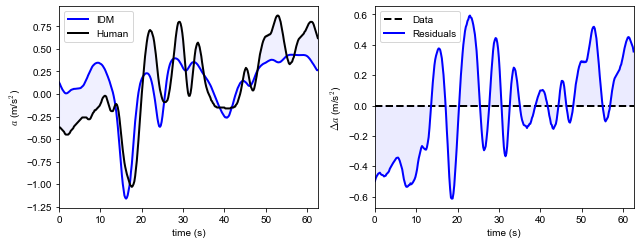

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


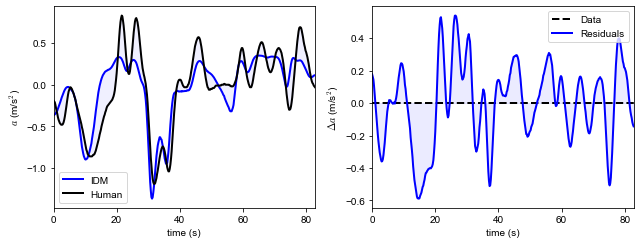

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


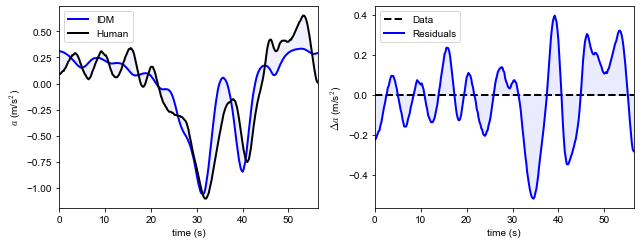

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


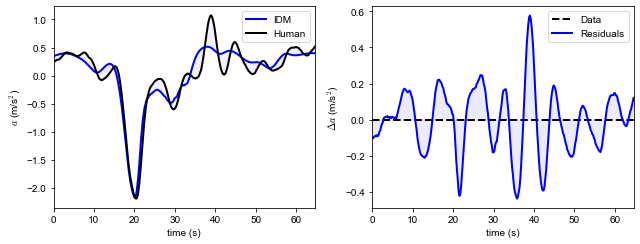

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


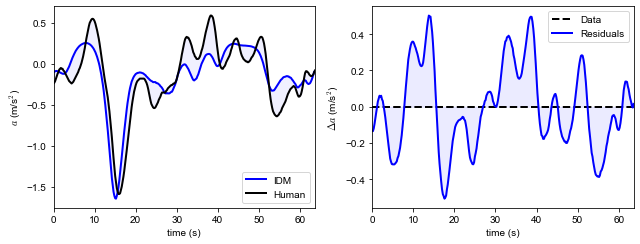

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


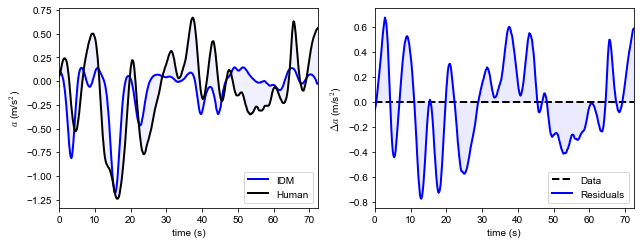

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


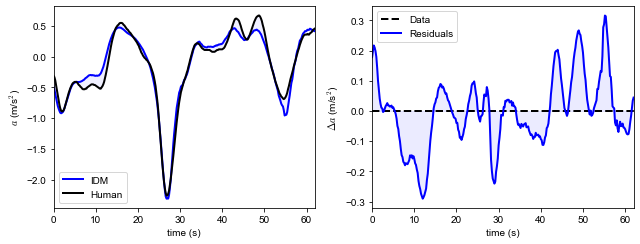

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


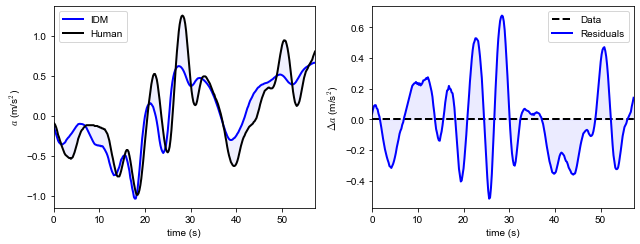

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


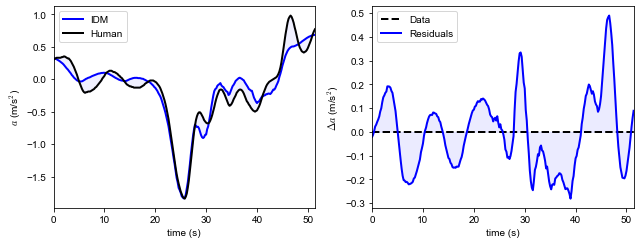

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


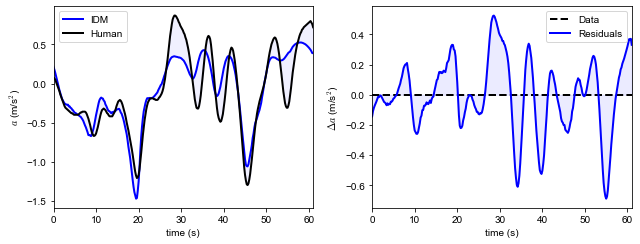

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


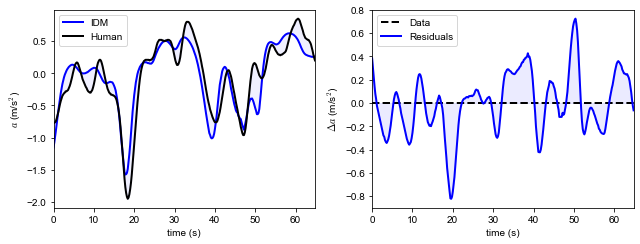

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


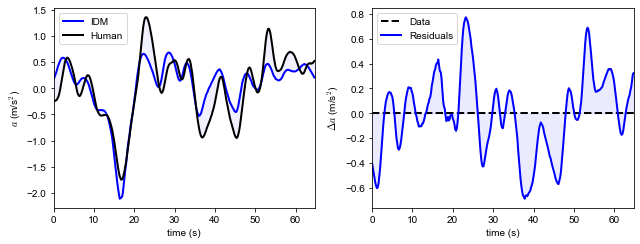

Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!


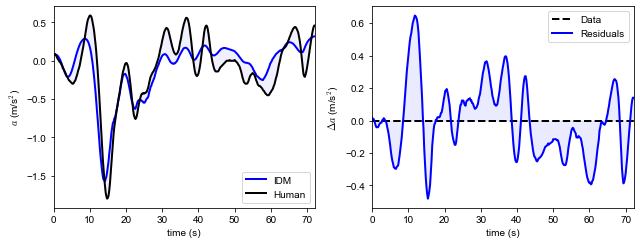

In [2]:
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
import scipy.io

plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

def IDM_a(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
    sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
    a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
    return a

def IDM_v(IDM_a, vt):
    return vt + IDM_a * Config.dt

def IDM_x(IDM_v, xt, vt):
    return xt + 0.5 * (IDM_v + vt) * Config.dt


for id_veh in range(20):
    def simulate(tr, sample_idx, print_values=False, mean=False):
        tracks = read_training_data(base_path=base_path, min_traj_lenth=50 * Config.frame_rate_orignial)
        if id_veh<=10:
            pair_id = Config.car_interactive_pair_list[id_veh-1]
            if mean:
                driver_para = tr.posterior.mu_d[:,:,id_veh-1,:].mean(axis=0).mean(axis=0).to_numpy()
            else:
                driver_para = tr.posterior.mu_d[:,sample_idx,id_veh-1,:].mean(axis=0).to_numpy()
        else:
            pair_id = Config.truck_interactive_pair_list[id_veh-1-10]
            if mean:
                driver_para = tr.posterior.mu_d[:,:,id_veh-1,:].mean(axis=0).mean(axis=0).to_numpy()
            else:
                driver_para = tr.posterior.mu_d[:,sample_idx,id_veh-1,:].mean(axis=0).to_numpy()

        driver_para *= [33, 2, 1.6, 1.5, 1.67]
        DELTA = 4 

        if print_values:
            print("Loading parameters for driver", str(pair_id))
            print(driver_para)

        x_leader, v_leader = tracks[pair_id]['xLeaderReal'], tracks[pair_id]['vLeaderReal']

        x_follower, v_follower, a_follower, vehicle_length = tracks[pair_id]['xFollReal'], \
                    tracks[pair_id]['vFollReal'], tracks[pair_id]['aFollReal'], tracks[pair_id]['vehicle_length']

        s_real = tracks[pair_id]['sReal']

        N = x_leader.shape[0]

        T = np.array(range(0, N))*Config.dt

        x_follower_temp = x_follower[0]
        v_follower_temp = v_follower[0]

        x_follower_sim = np.zeros(N)
        s_follower_sim = np.zeros(N)
        v_follower_sim = np.zeros(N)
        a_follower_sim = np.zeros(N)
        a_follower_sim_marginal = np.zeros(N)

        v_follower_sim[0] = v_follower_temp
        s_follower_sim[0] = s_real[0]

        for t in range(1, N):
            x_leader_temp = x_leader[t-1]
            v_leader_temp = v_leader[t-1]

            s = s_real[t-1]
            vt = v_follower[t-1]
            dv = v_follower[t-1] - v_leader[t-1]

            a_follower_temp = IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA, s, vt, dv)
            v_follower_temp = IDM_v(a_follower_temp, vt)
            x_follower_temp  = IDM_x(v_follower_temp, x_follower_temp, vt)

            x_follower_sim[t] = x_follower_temp
            s_follower_sim[t-1] = s
            v_follower_sim[t] = v_follower_temp
            a_follower_sim[t-1] = a_follower_temp
            a_follower_sim_marginal[t-1] = IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA, 3e2, -vt, vt)

        a_follower_sim[-1] = a_follower_sim[-2]
        s_follower_sim[-1] = s_follower_sim[-2]
        a_follower_sim_marginal[-1] = a_follower_sim_marginal[-2]

        return a_follower_sim, a_follower, a_follower_sim_marginal, v_follower_sim, v_follower, s_follower_sim, s_real, T

    base_path = '../data/highD/'

    cache = "../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl" # Bayesian_IDM_hierarchical AR4_IDM_hierarchical
    fp = open(cache, 'rb')
    tr_GP = pickle.load(fp)
    fp.close()
    print("Load trace", cache, ": done!")

    fig, _ = plt.subplots(figsize=(9, 3.5))

    linewidth_mean = 2
    color_sim_mean = 'blue'

    a_follower_sim_mean_GP, a_follower, a_follower_sim_marginal, v_follower_sim_mean_GP, v_follower, s_follower_sim_mean_GP, s_real, T = simulate(tr_GP, 0, mean=True)

    ax1 = plt.subplot(1,2,1)
    plt.plot(T,a_follower_sim_mean_GP,'-', color=color_sim_mean, label='IDM', linewidth=linewidth_mean, alpha=1)
    plt.plot(T,a_follower,'k-', label='Human', linewidth=linewidth_mean, alpha=1)
    ax1.fill_between(T, a_follower, a_follower_sim_mean_GP, color='blue', alpha=.06)
    plt.xlabel('time (s)')
    plt.ylabel('$a$ (m/s$^2$)')
    plt.legend(loc='best')

    ax2 = plt.subplot(1,2,2)
    plt.plot(T, np.zeros_like(T), '--', color='k', label='Data', linewidth=linewidth_mean, alpha=1)
    plt.plot(T, a_follower - a_follower_sim_mean_GP,'-', color=color_sim_mean, label='Residuals', linewidth=linewidth_mean, alpha=1)
    ax2.fill_between(T, a_follower - a_follower_sim_mean_GP, 0, color='blue', alpha=.08)
    plt.xlabel('time (s)')
    plt.ylabel('$\Delta a$ (m/s$^2$)')
    plt.legend(loc='best')
#     plt.title('ID: {:d}'.format(id_veh))

    ax1.set_xlim((0,T.max()))
    ax2.set_xlim((0,T.max()))
#     scipy.io.savemat('./cache/residual{:d}.mat'.format(id_veh), {'mydata': a_follower - a_follower_sim_mean_GP})

    plt.tight_layout()
#     fig.savefig('../Figs/noniid_{:02d}.pdf'.format(id_veh), dpi=300)
    plt.show()

# Hierarchical Dynamic IDM (AR+IDM) v.s. MA-IDM (GP+IDM)

## Stochastic simulations

Load trace ../PGM_highD_joint/cache/AR4_IDM_hierarchical.pkl : done!
Load trace ../PGM_highD/cache/MA_IDM_hierarchical.pkl : done!
Load tracks ../PGM_highD_joint/cache/AR4_hierarchical-sim-one-truck01-1000.pkl : done!
Simulation: 100 / 1000
Simulation: 200 / 1000
Simulation: 300 / 1000
Simulation: 400 / 1000
Simulation: 500 / 1000
Simulation: 600 / 1000
Simulation: 700 / 1000
Simulation: 800 / 1000
Simulation: 900 / 1000
Simulation: 1000 / 1000


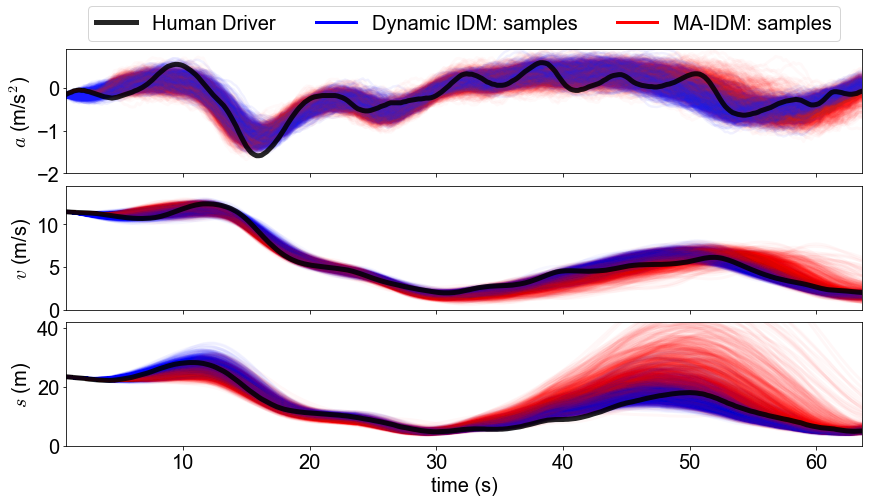

RMSE_ACC_AR samples 0.23030296264089528
RMSE_VEL_AR samples 0.5123583903258656
RMSE_GAP_AR samples 2.1278909465285656
RMSE_ACC_AR samples std 0.03238452940738993
RMSE_VEL_AR samples std 0.09929959192281879
RMSE_GAP_AR samples std 0.6480263378481298
RMSE_ACC_MA samples 0.2595756200753139
RMSE_VEL_MA samples 0.6709882966250175
RMSE_GAP_MA samples 4.361803967301797
RMSE_ACC_MA samples std 0.03553238505945162
RMSE_VEL_MA samples std 0.22677832363681621
RMSE_GAP_MA samples std 2.8716608532172168
---------------------------------------------------
RMSE_ACC_AR mean 0.21573249058685176
RMSE_VEL_AR mean 0.43168828014410343
RMSE_GAP_AR mean 1.4478588345115129
RMSE_ACC_MA mean 0.27552635849933244
RMSE_VEL_MA mean 0.7783813561387743
RMSE_GAP_MA mean 5.50092020508728
---------------------------------------------------


In [4]:
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
from sklearn.metrics.pairwise import rbf_kernel

import pickle
from pickle import UnpicklingError
import os
from os import path

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

np.random.seed(seed=1116)

def IDM_a(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
    sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
    a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
    return a

def IDM_v(IDM_a, vt):
    return vt + IDM_a * Config.dt

def IDM_x(IDM_v, xt, vt):
    return xt + 0.5 * (IDM_v + vt) * Config.dt

id_veh = 11

def simulate_AR(tr, sample_idx, d, print_values=False, mean=True, AR_flag=False):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=50 * Config.frame_rate_orignial)
    if id_veh<=10:
        pair_id = Config.car_interactive_pair_list[id_veh-1]
        if mean:
            driver_para = tr.posterior.mu_d[:,:,id_veh-1,:].mean(axis=0).mean(axis=0).to_numpy()
        else:
            driver_para = tr.posterior.mu_d[:,sample_idx,id_veh-1,:].mean(axis=0).to_numpy()
    else:
        pair_id = Config.truck_interactive_pair_list[id_veh-1-10]
        if mean:
            driver_para = tr.posterior.mu_d[:,:,id_veh-1,:].mean(axis=0).mean(axis=0).to_numpy()
        else:
            driver_para = tr.posterior.mu_d[:,sample_idx,id_veh-1,:].mean(axis=0).to_numpy()
    
    # Note that we have normalzied the IDM parameters when calibrating 
    driver_para *= [33, 2, 1.6, 1.5, 1.67]
    if AR_flag:
        rho = tr.posterior.rho[:,:,:].mean(axis=0).mean(axis=0).to_numpy()
        
    DELTA = 4 
    
    if print_values:
        print("Loading parameters for driver", str(pair_id))
        print(driver_para)

    x_leader, v_leader = tracks[pair_id]['xLeaderReal'], tracks[pair_id]['vLeaderReal']

    x_follower, v_follower, a_follower, vehicle_length = tracks[pair_id]['xFollReal'], \
                tracks[pair_id]['vFollReal'], tracks[pair_id]['aFollReal'], tracks[pair_id]['vehicle_length']

    s_real = tracks[pair_id]['sReal']

    N = x_leader.shape[0]

    T = np.array(range(0, N))*Config.dt

    x_follower_temp = x_follower[d]
    v_follower_temp = v_follower[d]

    x_follower_sim = np.zeros(N)
    s_follower_sim = np.zeros(N)
    v_follower_sim = np.zeros(N)
    a_follower_sim = np.zeros(N)

    v_follower_sim[0:d+1] = v_follower[0:d+1]
    s_follower_sim[0:d+1] = s_real[0:d+1]
    x_follower_sim[0:d+1] = x_follower[0:d+1]
    a_follower_sim[0:d] = a_follower[0:d]  
    
    if AR_flag:
        a_AR_sim = np.random.normal(0, tr.posterior.s_a.mean(axis=0).mean(axis=0), d)

    for t in range(d+1, N):
        x_leader_temp = x_leader[t-1]
        v_leader_temp = v_leader[t-1]
        
        s = x_leader_temp - x_follower_temp - vehicle_length[t-1]

        vt = v_follower_temp
        dv = v_follower_temp - v_leader_temp
        
        if AR_flag:
            a_AR_sim_temp = (rho * a_AR_sim).sum() + np.random.normal(0, tr.posterior.s_a.mean(axis=0).mean(axis=0))
        else:
            a_AR_sim_temp = np.random.normal(0, tr_MA.posterior.s_a.mean())
        a_follower_temp = np.max((a_AR_sim_temp + IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA, s, vt, dv), -3))
        v_follower_temp = np.max((IDM_v(a_follower_temp, vt), 0))
        x_follower_temp  = IDM_x(v_follower_temp, x_follower_temp, vt)

        x_follower_sim[t] = x_follower_temp
        s_follower_sim[t-1] = s
        v_follower_sim[t] = v_follower_temp
        a_follower_sim[t-1] = a_follower_temp
        if AR_flag:
            a_AR_sim[:-1] = a_AR_sim[1:]
            a_AR_sim[-1] = a_AR_sim_temp

    a_follower_sim[-1] = a_follower_sim[-2]
    s_follower_sim[-1] = s_follower_sim[-2]

    return a_follower_sim, a_follower, v_follower_sim, v_follower, s_follower_sim, s_real, T, x_leader, x_follower, vehicle_length[0]

# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1),
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)  + 1e-6 * np.eye(X1.shape[0])
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12).T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

def simulate_GP(tr, sample_idx, print_values=False, mean=True, GP_flag=False):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=50 * Config.frame_rate_orignial)
    if id_veh <= 10:
        pair_id = Config.car_interactive_pair_list[id_veh - 1]
        if mean:
            driver_para = tr.posterior.mu_d[:, :, id_veh - 1, :].mean(axis=0).mean(axis=0).to_numpy()
        else:
            driver_para = tr.posterior.mu_d[:, sample_idx, id_veh - 1, :].mean(axis=0).to_numpy()
    else:
        pair_id = Config.truck_interactive_pair_list[id_veh - 1 - 10]
        if mean:
            driver_para = tr.posterior.mu_d[:, :, id_veh - 1, :].mean(axis=0).mean(axis=0).to_numpy()
        else:
            driver_para = tr.posterior.mu_d[:, sample_idx, id_veh - 1, :].mean(axis=0).to_numpy()

    # Note that we have normalzied the IDM parameters when calibrating 
    driver_para *= [33, 2, 1.6, 1.5, 1.67]
    DELTA = 4

    if print_values:
        print("Loading parameters for driver", str(pair_id))
        print(driver_para)

    x_leader, v_leader = tracks[pair_id]['xLeaderReal'], tracks[pair_id]['vLeaderReal']

    x_follower, v_follower, a_follower, vehicle_length = tracks[pair_id]['xFollReal'], \
                                                         tracks[pair_id]['vFollReal'], tracks[pair_id]['aFollReal'], \
                                                         tracks[pair_id]['vehicle_length']

    s_real = tracks[pair_id]['sReal']

    N = x_leader.shape[0]

    T = np.array(range(0, N)) * Config.dt

    x_follower_temp = x_follower[sample_dim]
    v_follower_temp = v_follower[sample_dim]

    x_follower_sim = np.zeros(N)
    s_follower_sim = np.zeros(N)
    v_follower_sim = np.zeros(N)
    a_follower_sim = np.zeros(N)

    v_follower_sim[:sample_dim + 1] = v_follower[:sample_dim + 1]
    s_follower_sim[:sample_dim + 1] = s_real[:sample_dim + 1]
    a_follower_sim[:sample_dim] = a_follower[:sample_dim]

    if GP_flag:
        l = tr.posterior.l.mean(axis=0).mean(axis=0).to_numpy()
        s_f = np.sqrt(tr.posterior.s2_f.mean(axis=0).mean(axis=0)).to_numpy()

        def RBF_kernel(XA, XB, l=l, A=s_f):
            X_dist = A ** 2 * rbf_kernel(XA[:, [0]], XB[:, [0]], gamma=0.5 / l ** 2)
            return X_dist

        X1 = np.expand_dims(np.linspace(-sample_dim, -1, sample_dim), 1)
        y1 = a_follower[:sample_dim] - \
             IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA,
                   s_real[:sample_dim], v_follower[:sample_dim], v_follower[:sample_dim] - v_leader[:sample_dim])
        X2 = np.expand_dims(np.linspace(0, 1, 2), 1)

    for t in range(sample_dim + 1, N):
        x_leader_temp = x_leader[t - 1]
        v_leader_temp = v_leader[t - 1]

        s = x_leader_temp - x_follower_temp - vehicle_length[t - 1]
        vt = v_follower_temp
        dv = v_follower_temp - v_leader_temp

        if GP_flag:
            μ2, Σ2 = GP(X1, y1, X2, RBF_kernel)
            a_GP_sim = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=1)
            a_GP_sim_temp = a_GP_sim[0, 0] + np.random.normal(0, np.sqrt(tr.posterior.s2_a.mean(axis=0).mean(axis=0)))
        else:
            a_GP_sim_temp = np.random.normal(0, tr_MA.posterior.s_a.mean())

        a_follower_temp = a_GP_sim_temp + IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3],
                                                driver_para[4], DELTA, s, vt, dv)
        v_follower_temp = IDM_v(a_follower_temp, vt)
        x_follower_temp = IDM_x(v_follower_temp, x_follower_temp, vt)

        x_follower_sim[t] = x_follower_temp
        s_follower_sim[t] = s
        v_follower_sim[t] = v_follower_temp
        a_follower_sim[t - 1] = a_follower_temp

        if GP_flag:
            y1[:-1] = y1[1:]
            y1[-1] = a_GP_sim[0, 0]

    a_follower_sim[-1] = a_follower_sim[-2]

    return a_follower_sim, a_follower, v_follower_sim, v_follower, s_follower_sim, s_real, T, x_leader, x_follower, vehicle_length[0]
    
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(12, 7))

print_values = False
sample_num = 1000
counter = 0

linewidth = 3.
linewidth_mean = 2
linewidth_gt = 5
color_sim = 'blue'
color_sim_MA = 'red'
color_sim_gt = 'k'
alpha = 0.03

RMSE_ACC_AR = np.zeros(sample_num)
RMSE_VEL_AR = np.zeros(sample_num)
RMSE_GAP_AR = np.zeros(sample_num)
RMSE_ACC_MA = np.zeros(sample_num)
RMSE_VEL_MA = np.zeros(sample_num)
RMSE_GAP_MA = np.zeros(sample_num)

d = 4

base_path = '../data/highD/'

cache = "../PGM_highD_joint/cache/AR{:01d}_IDM_hierarchical.pkl".format(d)
with open(cache, 'rb') as fp:
    tr_AR = pickle.load(fp)
print("Load trace", cache, ": done!")

cache = "../PGM_highD/cache/MA_IDM_hierarchical.pkl"
with open(cache, 'rb') as fp:
    tr_MA = pickle.load(fp)
    sample_dim = int(2 * tr_MA.posterior.l.mean(axis=0).mean(axis=0).to_numpy()) + 1
print("Load trace", cache, ": done!")

if id_veh<=10:
    cache = "../PGM_highD_joint/cache/AR{:01d}_hierarchical-sim-one-car{:02d}-".format(d, id_veh) + str(sample_num) + ".pkl"
else:
    cache = "../PGM_highD_joint/cache/AR{:01d}_hierarchical-sim-one-truck{:02d}-".format(d, id_veh-10) + str(sample_num) + ".pkl"

a_follower_sim_mean_AR, a_follower, v_follower_sim_mean_AR, v_follower, s_follower_sim_mean_AR, s_real, T, _, _, _ = simulate_AR(tr_AR, 0, d=d, print_values=print_values, mean=True, AR_flag=True)
a_follower_sim_mean_MA, _, v_follower_sim_mean_MA, _, s_follower_sim_mean_MA, _, _, _, _, _ = simulate_GP(tr_MA, 0, print_values=print_values, mean=True, GP_flag=True)

if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tracks = pickle.load(fp)
        fp.close()
        print("Load tracks", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    tracks = [None]*sample_num

    
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

for sample_idx in np.random.choice(range(2000), sample_num, replace=False): #range(sample_num):#
    if not path.exists(cache):
        a_follower_sim_AR, _, v_follower_sim_AR, _, s_follower_sim_AR, _, T, _, _, _ = simulate_AR(tr_AR, sample_idx, d=d, print_values=print_values, mean=True, AR_flag=True)
        a_follower_sim_MA, _, v_follower_sim_MA, _, s_follower_sim_MA, _, T, _, _, _ = simulate_GP(tr_MA, sample_idx, print_values=print_values, mean=True, GP_flag=True)

        RMSE_ACC_AR[counter] = np.sqrt(mean_squared_error(a_follower_sim_AR, a_follower))
        RMSE_VEL_AR[counter] = np.sqrt(mean_squared_error(v_follower_sim_AR, v_follower))
        RMSE_GAP_AR[counter] = np.sqrt(mean_squared_error(s_follower_sim_AR, s_real))

        RMSE_ACC_MA[counter] = np.sqrt(mean_squared_error(a_follower_sim_MA, a_follower))
        RMSE_VEL_MA[counter] = np.sqrt(mean_squared_error(v_follower_sim_MA, v_follower))
        RMSE_GAP_MA[counter] = np.sqrt(mean_squared_error(s_follower_sim_MA, s_real))

        tracks[counter] = {
            'a_follower_sim_AR': a_follower_sim_AR,
            'v_follower_sim_AR': v_follower_sim_AR,
            's_follower_sim_AR': s_follower_sim_AR,
            'a_follower_sim_MA': a_follower_sim_MA,
            'v_follower_sim_MA': v_follower_sim_MA,
            's_follower_sim_MA': s_follower_sim_MA,
            'RMSE_ACC_AR': np.sqrt(mean_squared_error(a_follower_sim_AR, a_follower)),
            'RMSE_VEL_AR': np.sqrt(mean_squared_error(v_follower_sim_AR, v_follower)),
            'RMSE_GAP_AR': np.sqrt(mean_squared_error(s_follower_sim_AR, s_real)),
            'RMSE_ACC_MA': np.sqrt(mean_squared_error(a_follower_sim_MA, a_follower)),
            'RMSE_VEL_MA': np.sqrt(mean_squared_error(v_follower_sim_MA, v_follower)),
            'RMSE_GAP_MA': np.sqrt(mean_squared_error(s_follower_sim_MA, s_real)),
        }
    else:
        a_follower_sim_AR = tracks[counter]['a_follower_sim_AR']
        v_follower_sim_AR = tracks[counter]['v_follower_sim_AR']
        s_follower_sim_AR = tracks[counter]['s_follower_sim_AR']
        a_follower_sim_MA = tracks[counter]['a_follower_sim_MA']
        v_follower_sim_MA = tracks[counter]['v_follower_sim_MA']
        s_follower_sim_MA = tracks[counter]['s_follower_sim_MA']
        RMSE_ACC_AR[counter] = tracks[counter]['RMSE_ACC_AR']
        RMSE_VEL_AR[counter] = tracks[counter]['RMSE_VEL_AR']
        RMSE_GAP_AR[counter] = tracks[counter]['RMSE_GAP_AR']
        RMSE_ACC_MA[counter] = tracks[counter]['RMSE_ACC_MA']
        RMSE_VEL_MA[counter] = tracks[counter]['RMSE_VEL_MA']
        RMSE_GAP_MA[counter] = tracks[counter]['RMSE_GAP_MA']
    
    counter += 1
    if print_values:
        print("RMSE_ACC_MA:", RMSE_ACC_MA[counter])
        print("RMSE_ACC_AR:", RMSE_ACC_AR[counter])

        print("RMSE_VEL_MA:", RMSE_VEL_MA[counter])
        print("RMSE_VEL_AR:", RMSE_VEL_AR[counter])

        print("RMSE_GAP_MA:", RMSE_GAP_MA[counter])
        print("RMSE_GAP_AR:", RMSE_GAP_AR[counter])
    ######################################################################################################
    if counter % 1==0:
        plt.subplot(3,1,1)
        plt.plot(T[d:],a_follower_sim_MA[d:],'-', color=lighten_color(color_sim_MA, .9), linewidth=linewidth, alpha=.8*alpha)
        plt.plot(T[d:],a_follower_sim_AR[d:],'-', color=lighten_color(color_sim, .9), linewidth=0.8*linewidth, alpha=2*alpha)

    plt.subplot(3,1,2)
    plt.plot(T[d:],v_follower_sim_AR[d:],'-', color=color_sim, linewidth=linewidth, alpha=alpha)
    plt.plot(T[d:],v_follower_sim_MA[d:],'-', color=color_sim_MA, linewidth=linewidth, alpha=alpha)

    plt.subplot(3,1,3)
    plt.plot(T[d:],s_follower_sim_AR[d:],'-', color=color_sim, linewidth=linewidth, alpha=alpha)
    plt.plot(T[d:],s_follower_sim_MA[d:],'-', color=color_sim_MA, linewidth=linewidth, alpha=alpha)
    if counter % 100==0:
        print("Simulation:", counter, "/", sample_num)

if not path.exists(cache):
    output_file = open(cache, 'wb')
    pickle.dump(tracks, output_file)
    output_file.close()
    print("Generated and Saved", output_file, ": done!")

#########################################
plt.subplot(3,1,1)
plt.plot(T[d:],a_follower[d:],'-', color=color_sim_gt,label='Human Driver', linewidth=linewidth_gt, alpha=0.85)
plt.ylabel('$a$ (m/s$^2$)')

plt.subplot(3,1,2)
plt.plot(T[d:],v_follower[d:],'-', color=color_sim_gt,label='Human Driver', linewidth=linewidth_gt, alpha=0.85)
plt.ylabel('$v$ (m/s)')

plt.subplot(3,1,3)
plt.plot(T[d:],s_real[d:],'-', color=color_sim_gt,label='Human Driver', linewidth=linewidth_gt, alpha=0.85)
plt.xlabel('time (s)')
plt.ylabel('$s$ (m)')

plt.subplot(3,1,1)
plt.plot(0,0,'-', color=color_sim, label='Dynamic IDM: samples', linewidth=linewidth, alpha=1)
plt.plot(0,0,'-', color=color_sim_MA, label='MA-IDM: samples', linewidth=linewidth, alpha=1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.43), fancybox=True, ncol=3)

plt.subplot(3,1,2)
plt.plot(0,0,'-', color=color_sim, label='Dynamic IDM: samples', linewidth=linewidth, alpha=1)
plt.plot(0,0,'-', color=color_sim_MA, label='MA-IDM: samples', linewidth=linewidth, alpha=1)

plt.subplot(3,1,3)
plt.plot(0,0,'-', color=color_sim, label='Dynamic IDM: samples', linewidth=linewidth, alpha=1)
plt.plot(0,0,'-', color=color_sim_MA, label='MA-IDM: samples', linewidth=linewidth, alpha=1)

ax1.set_xlim((d*Config.dt,T.max()))
ax2.set_xlim((d*Config.dt,T.max()))
ax3.set_xlim((d*Config.dt,T.max()))

# ID:11 and 1
ax1.set_ylim((-2,.9))
ax2.set_ylim((0,14.5))
ax3.set_ylim((0,42))

# ID:14
# ax1.set_ylim((-1.5,1.37))
# ax2.set_ylim((0,12.5))
# ax3.set_ylim((0,40))

# ID:19
# ax1.set_ylim((-2,0.9))
# ax2.set_ylim((0,13.5))
# ax3.set_ylim((0,25))

# ID:15 
# ax1.set_ylim((-2.3,1.3))
# ax2.set_ylim((0,15))
# ax3.set_ylim((0,22))

ax1.set_rasterized(True)
ax2.set_rasterized(True)
ax3.set_rasterized(True)

plt.tight_layout(h_pad=0.05, rect=(-0.018, -0.027, 1.069, 1.018))
# fig.savefig('../Figs/Hierarchical_AR{:01d}vsGP_sim_id{:d}.pdf'.format(d,id_veh), dpi=300)
plt.show()

print("RMSE_ACC_AR samples", RMSE_ACC_AR.mean())
print("RMSE_VEL_AR samples", RMSE_VEL_AR.mean())
print("RMSE_GAP_AR samples", RMSE_GAP_AR.mean())

print("RMSE_ACC_AR samples std", RMSE_ACC_AR.std())
print("RMSE_VEL_AR samples std", RMSE_VEL_AR.std())
print("RMSE_GAP_AR samples std", RMSE_GAP_AR.std())

print("RMSE_ACC_MA samples", RMSE_ACC_MA.mean())
print("RMSE_VEL_MA samples", RMSE_VEL_MA.mean())
print("RMSE_GAP_MA samples", RMSE_GAP_MA.mean())

print("RMSE_ACC_MA samples std", RMSE_ACC_MA.std())
print("RMSE_VEL_MA samples std", RMSE_VEL_MA.std())
print("RMSE_GAP_MA samples std", RMSE_GAP_MA.std())

print("---------------------------------------------------")

print("RMSE_ACC_AR mean", np.sqrt(mean_squared_error(a_follower_sim_mean_AR, a_follower)))
print("RMSE_VEL_AR mean", np.sqrt(mean_squared_error(v_follower_sim_mean_AR, v_follower)))
print("RMSE_GAP_AR mean", np.sqrt(mean_squared_error(s_follower_sim_mean_AR, s_real)))

print("RMSE_ACC_MA mean", np.sqrt(mean_squared_error(a_follower_sim_mean_MA, a_follower)))
print("RMSE_VEL_MA mean", np.sqrt(mean_squared_error(v_follower_sim_mean_MA, v_follower)))
print("RMSE_GAP_MA mean", np.sqrt(mean_squared_error(s_follower_sim_mean_MA, s_real)))

print("---------------------------------------------------")

## Relative spacing diagram

Simulation: 100 / 1000
Simulation: 200 / 1000
Simulation: 300 / 1000
Simulation: 400 / 1000
Simulation: 500 / 1000
Simulation: 600 / 1000
Simulation: 700 / 1000
Simulation: 800 / 1000
Simulation: 900 / 1000
Simulation: 1000 / 1000


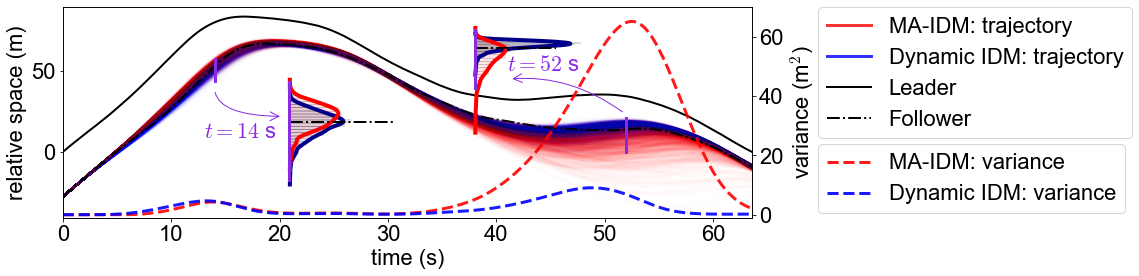

In [5]:
import seaborn as sns

plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'

np.random.seed(seed=1116)

print_values = False
sample_num = 1000
counter = 0

linewidth = 3.
linewidth_mean = 2
linewidth_gt = 5
color_sim = 'blue'
color_sim_MA = 'red'
color_sim_gt = 'k'
alpha = 0.01

a_follower_sim_mean_AR, a_follower, v_follower_sim_mean_AR, v_follower, s_follower_sim_mean_AR, s_real, T, x_leader, x_follower, vl = simulate_AR(tr_AR, 0, d=d, print_values=print_values, mean=True, AR_flag=True)
a_follower_sim_mean_MA, _, v_follower_sim_mean_MA, _, s_follower_sim_mean_MA, _, _, _, _, _ = simulate_GP(tr_MA, 0, print_values=print_values, mean=True, GP_flag=True)

fig, ax1 = plt.subplots(figsize=(16, 4))

x_mean = np.linspace(x_leader[0], x_leader[-1], x_leader.shape[0])

s_follower_sim_AR_all = np.zeros((len(tracks), tracks[0]['s_follower_sim_AR'].shape[0]))
s_follower_sim_MA_all = np.zeros_like(s_follower_sim_AR_all)
traj_sim_AR_all = np.zeros_like(s_follower_sim_AR_all)
traj_sim_MA_all = np.zeros_like(s_follower_sim_AR_all)

for sample_idx in np.random.choice(range(2000), sample_num, replace=False):  # range(sample_num):#
    a_follower_sim_AR = tracks[counter]['a_follower_sim_AR']
    v_follower_sim_AR = tracks[counter]['v_follower_sim_AR']
    s_follower_sim_AR = tracks[counter]['s_follower_sim_AR']
    a_follower_sim_MA = tracks[counter]['a_follower_sim_MA']
    v_follower_sim_MA = tracks[counter]['v_follower_sim_MA']
    s_follower_sim_MA = tracks[counter]['s_follower_sim_MA']

    counter += 1
    
    traj_sim_AR_all[counter - 1, :] = x_leader - s_follower_sim_AR - vl - x_mean
    traj_sim_MA_all[counter - 1, :] = x_leader - s_follower_sim_MA - vl - x_mean
    if counter % 1 == 0:
        plt.plot(T, traj_sim_AR_all[counter - 1, :], '-', color=lighten_color(color_sim, .99), linewidth=linewidth,
                 alpha=alpha)
        plt.plot(T, traj_sim_MA_all[counter - 1, :], '-', color=lighten_color(color_sim_MA, .99), linewidth=linewidth,
                 alpha=alpha)
    if counter % 100 == 0:
        print("Simulation:", counter, "/", sample_num)

for i in range(len(tracks)):
    s_follower_sim_MA_all[i, :] = tracks[i]['s_follower_sim_MA']
    s_follower_sim_AR_all[i, :] = tracks[i]['s_follower_sim_AR']

plt.plot(0, (x_leader - s_follower_sim_MA - vl - x_mean)[0], '-', color=lighten_color(color_sim_MA, .8),
         linewidth=linewidth, label='MA-IDM: trajectory')
plt.plot(0, (x_leader - s_follower_sim_AR - vl - x_mean)[0], '-', color=lighten_color(color_sim, .8),
         linewidth=linewidth, label='Dynamic IDM: trajectory')

plt.plot(T, x_leader - x_mean, 'k', label='Leader', linewidth=2)
plt.plot(T, x_follower - x_mean, 'k-.', label='Follower', linewidth=2)

t = 14
t_index = int(t / Config.dt)
ax1.plot(t * np.ones(sample_num), traj_sim_AR_all[:, t_index], '-', color='blueviolet', linewidth=3)

ax_new1 = fig.add_axes([.245, .32, .1, .4])
sns.distplot(traj_sim_AR_all[:, t_index], hist=True, kde=True,
             color='darkblue', vertical=True, ax=ax_new1,
             hist_kws={'edgecolor': 'black', 'alpha': 0.1},
             kde_kws={'linewidth': 4})
sns.distplot(traj_sim_MA_all[:, t_index], hist=True, kde=True,
             color='red', vertical=True, ax=ax_new1,
             hist_kws={'edgecolor': 'black', 'alpha': 0.1},
             kde_kws={'linewidth': 4})

pos_1 = (x_follower - x_mean)[t_index]
ax_new1.plot([0, .4], [pos_1, pos_1], 'k-.', linewidth=2)
ax_new1.plot([-0.002, -0.002], [43, 60], '-', color='blueviolet', linewidth=3)
ax_new1.set_xticklabels([''])
ax_new1.set_yticklabels([''])
ax_new1.axis('off')

t = 52
t_index = int(t / Config.dt)
ax1.plot(t * np.ones(sample_num), traj_sim_AR_all[:, t_index], '-', color='blueviolet', linewidth=3)

ax_new2 = fig.add_axes([.406, .5, .1, .4])
sns.distplot(traj_sim_AR_all[:, t_index], hist=True, kde=True,
             color='darkblue', vertical=True, ax=ax_new2,
             hist_kws={'edgecolor': 'black', 'alpha': 0.1},
             kde_kws={'linewidth': 4})
sns.distplot(traj_sim_MA_all[:, t_index], hist=True, kde=True,
             color='red', vertical=True, ax=ax_new2,
             hist_kws={'edgecolor': 'black', 'alpha': 0.1},
             kde_kws={'linewidth': 4})

pos_2 = (x_follower - x_mean)[t_index]
ax_new2.plot([0, 0.16], [pos_2, pos_2], 'k-.', linewidth=2)
ax_new2.plot([-0.001, -0.001], [-10, 25], '-', color='blueviolet', linewidth=3)
ax_new2.set_xticklabels([''])
ax_new2.set_yticklabels([''])
ax_new2.axis('off')

ax1.set_xlim((0, T.max()))

ax1.set_rasterized(True)
ax2.set_rasterized(True)

ax1.set_xlabel('time (s)')
ax1.set_ylabel('relative space (m)')
ax1.legend(bbox_to_anchor=(1.08, 1.05))

# twin object for two different y-axis on the sample plot
ax2 = ax1.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(T, np.var(s_follower_sim_MA_all, axis=0), color="red", linestyle='--', linewidth=3, alpha=.9,
         label='MA-IDM: variance')
ax2.plot(T, np.var(s_follower_sim_AR_all, axis=0), color="blue", linestyle='--', linewidth=3, alpha=.9,
         label='Dynamic IDM: variance')
ax2.set_ylabel("variance (m$^2$)", color="k")
ax2.set_ylim(-1,70)
ax2.legend(bbox_to_anchor=(1.08, 0.4))

ax1.annotate("",
             xy=(20.5, 22), xycoords='data',
             xytext=(14, 40), textcoords='data',
             arrowprops=dict(arrowstyle="->", color="blueviolet",
                             shrinkA=5, shrinkB=5,
                             patchA=None, patchB=None,
                             connectionstyle="angle3,angleA=90,angleB=0",
                             ),
             )

ax1.annotate("",
             xy=(41, 45), xycoords='data',
             xytext=(52, 23), textcoords='data',
             arrowprops=dict(arrowstyle="->", color="blueviolet",
                             shrinkA=5, shrinkB=5,
                             patchA=None, patchB=None,
                             connectionstyle="angle3,angleA=-37,angleB=6",
                             ),
             )
ax1.text(x=13, y=8.7, s='$t=14$ s', color='blueviolet')
ax1.text(x=41, y=50, s='$t=52$ s', color='blueviolet')

plt.tight_layout(rect=(-0.016, -0.037, 1.016, 1.037))
# fig.savefig('../Figs/Hierarchical_AR{:01d}vsGP_sim_truck_CFpairID{:d}.pdf'.format(d,id_veh), dpi=300)
plt.show()

## Evaluation with RMSE and CRPS for randomly sampled 5-sec fractions

Load trace ../PGM_highD_joint/cache/AR4_IDM_hierarchical.pkl : done!
Load trace ../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl : done!
Simulation at time point: 10 / 50
Simulation at time point: 20 / 50
Simulation at time point: 30 / 50
Simulation at time point: 40 / 50
Simulation at time point: 50 / 50
RMSE_ACC_AR samples 0.12549430967666325
RMSE_VEL_AR samples 0.21374468514151904
RMSE_GAP_AR samples 0.36624617953043787
RMSE_ACC_AR samples std 0.05617625954757003
RMSE_VEL_AR samples std 0.1459486059644644
RMSE_GAP_AR samples std 0.26864356107051834
RMSE_ACC_B samples 0.2950674202845252
RMSE_VEL_B samples 0.2625865993265401
RMSE_GAP_B samples 0.5461645068297099
RMSE_ACC_B samples std 0.048827466668069815
RMSE_VEL_B samples std 0.12827174028415783
RMSE_GAP_B samples std 0.3456105680084229
crps_a_AR: 0.06925958837390966
crps_v_AR: 0.11497167073629697
crps_s_AR: 0.1746179023059955
crps_a_B: 0.1036729596353253
crps_v_B: 0.16776025330324287
crps_s_B: 0.3373851212261296
crps_a_AR std

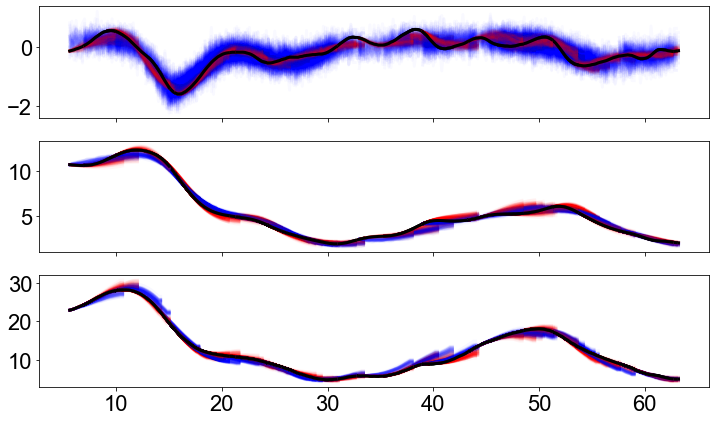

In [15]:
import pickle
from pickle import UnpicklingError
import os
from os import path
import sys
import numpy as np

import scipy
import CRPS.CRPS as pscore

sys.path.append('../')
from data.data_loader import read_training_data

import warnings

warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel

sys.path.append('../')
from config import Config

np.random.seed(seed=1116)

def IDM_a(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
    sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
    a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
    return a


def IDM_v(IDM_a, vt):
    return vt + IDM_a * Config.dt


def IDM_x(IDM_v, xt, vt):
    return xt + 0.5 * (IDM_v + vt) * Config.dt


id_veh = 11
d = 1

sim_length = int(5 / Config.dt) + 1 + d
tracks = read_training_data(base_path='../data/highD/', min_traj_lenth=50 * Config.frame_rate_orignial)

if id_veh <= 10:
    pair_id = Config.car_interactive_pair_list[id_veh - 1]
else:
    pair_id = Config.truck_interactive_pair_list[id_veh - 1 - 10]

N_total = tracks[pair_id]['xLeaderReal'].shape[0]


def simulate(tr, sample_idx, t0=0, print_values=False, mean=False, AR_flag=False):
    tracks = read_training_data(base_path='../data/highD/', min_traj_lenth=50 * Config.frame_rate_orignial)
    if id_veh <= 10:
        if mean:
            driver_para = tr.posterior.mu_d[:, :, id_veh - 1, :].mean(axis=0).mean(axis=0).to_numpy()
        else:
            driver_para = tr.posterior.mu_d[:, sample_idx, id_veh - 1, :].mean(axis=0).to_numpy()
    else:
        if mean:
            driver_para = tr.posterior.mu_d[:, :, id_veh - 1, :].mean(axis=0).mean(axis=0).to_numpy()
        else:
            driver_para = tr.posterior.mu_d[:, sample_idx, id_veh - 1, :].mean(axis=0).to_numpy()

    if AR_flag:
        rho = tr.posterior.rho[:, :, :].mean(axis=0).mean(axis=0).to_numpy()

    driver_para *= [33, 2, 1.6, 1.5, 1.67]
    DELTA = 4

    if print_values:
        print("Loading parameters for driver", str(pair_id))
        print(driver_para)

    x_leader, v_leader = tracks[pair_id]['xLeaderReal'][t0:t0 + sim_length], \
                         tracks[pair_id]['vLeaderReal'][t0:t0 + sim_length]

    x_follower, v_follower, a_follower, vehicle_length = tracks[pair_id]['xFollReal'][t0:t0 + sim_length], \
                                                         tracks[pair_id]['vFollReal'][t0:t0 + sim_length], \
                                                         tracks[pair_id]['aFollReal'][t0:t0 + sim_length], \
                                                         tracks[pair_id]['vehicle_length'][t0:t0 + sim_length]

    s_real = tracks[pair_id]['sReal'][t0:t0 + sim_length]

    N = sim_length

    T = np.array(range(t0, t0 + N)) * Config.dt

    x_follower_temp = x_follower[d]
    v_follower_temp = v_follower[d]

    x_follower_sim = np.zeros(N)
    s_follower_sim = np.zeros(N)
    v_follower_sim = np.zeros(N)
    a_follower_sim = np.zeros(N)

    v_follower_sim[0:d + 1] = v_follower[0:d + 1]
    s_follower_sim[0:d + 1] = s_real[0:d + 1]
    x_follower_sim[0:d + 1] = x_follower[0:d + 1]
    a_follower_sim[0:d] = a_follower[0:d]

    if AR_flag:
        a_AR_sim = a_follower[0:d] - \
                   IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3], driver_para[4], DELTA,
                         s_real[0:d], v_follower[0:d], v_follower[0:d] - v_leader[0:d])

    for t in range(d + 1, N):
        x_leader_temp = x_leader[t - 1]
        v_leader_temp = v_leader[t - 1]

        s = x_leader_temp - x_follower_temp - vehicle_length[t - 1]
        vt = v_follower_temp
        dv = v_follower_temp - v_leader_temp

        if AR_flag:
            a_AR_sim_temp = (rho * a_AR_sim).sum() + np.random.normal(0, tr.posterior.s_a.mean(axis=0).mean(axis=0))
        else:
            a_AR_sim_temp = np.random.normal(0, tr_B.posterior.s_a.mean())
        
        a_follower_temp = np.max((a_AR_sim_temp + IDM_a(driver_para[0], driver_para[1], driver_para[2], driver_para[3],
                                                        driver_para[4], DELTA, s, vt, dv), -3))
        v_follower_temp = np.max((IDM_v(a_follower_temp, vt), 0))
        x_follower_temp = IDM_x(v_follower_temp, x_follower_temp, vt)

        x_follower_sim[t] = x_follower_temp
        s_follower_sim[t-1] = s
        v_follower_sim[t] = v_follower_temp
        a_follower_sim[t - 1] = a_follower_temp
        if AR_flag:
            a_AR_sim[:-1] = a_AR_sim[1:]
            a_AR_sim[-1] = a_AR_sim_temp

    a_follower_sim[-1] = a_follower_sim[-2]
    s_follower_sim[-1] = s_follower_sim[-2]

    return a_follower_sim[d:], a_follower[d:], v_follower_sim[d:], v_follower[d:], s_follower_sim[d:], s_real[d:], T[d:]


base_path = '../data/highD/'

cache = "../PGM_highD_joint/cache/AR{:01d}_IDM_hierarchical.pkl".format(d)
fp = open(cache, 'rb')
tr_AR = pickle.load(fp)
fp.close()
print("Load trace", cache, ": done!")

cache = "../PGM_highD_joint/cache/Bayesian_IDM_hierarchical.pkl"
fp = open(cache, 'rb')
tr_B = pickle.load(fp)
fp.close()
print("Load trace", cache, ": done!")

################
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(12, 7))
linewidth = 3.
linewidth_mean = 2
linewidth_gt = 5
color_sim = 'red'
color_sim_mean = 'yellow'
color_sim_B = 'blue'
color_sim_mean_B = 'fuchsia'
color_sim_gt = 'k'
alpha = 0.03
################

print_values = False
sample_num = 50
sample_num_t = 50

RMSE_ACC_AR = np.zeros(sample_num * sample_num_t)
RMSE_VEL_AR = np.zeros(sample_num * sample_num_t)
RMSE_GAP_AR = np.zeros(sample_num * sample_num_t)
RMSE_ACC_B = np.zeros(sample_num * sample_num_t)
RMSE_VEL_B = np.zeros(sample_num * sample_num_t)
RMSE_GAP_B = np.zeros(sample_num * sample_num_t)
crps_a_AR = np.zeros(sample_num_t)
crps_v_AR = np.zeros(sample_num_t)
crps_s_AR = np.zeros(sample_num_t)
crps_a_B = np.zeros(sample_num_t)
crps_v_B = np.zeros(sample_num_t)
crps_s_B = np.zeros(sample_num_t)

tracks = [None] * sample_num * sample_num_t

counter = 0
counter_t = 0
for t in np.random.choice(range(int(4 / Config.dt), N_total - sim_length), sample_num_t, replace=False):
    for sample_idx in np.random.choice(range(2000), sample_num, replace=False):  # range(sample_num):#
        a_follower_sim_AR, a_follower, v_follower_sim_AR, v_follower, \
        s_follower_sim_AR, s_real, T = simulate(tr_AR, sample_idx, t, print_values, mean=True, AR_flag=True)
        a_follower_sim_B, _, v_follower_sim_B, _, s_follower_sim_B, _, _ = simulate(tr_B, sample_idx, t, print_values,
                                                                                    mean=True)

        RMSE_ACC_AR[counter] = np.sqrt(mean_squared_error(a_follower_sim_AR, a_follower))
        RMSE_VEL_AR[counter] = np.sqrt(mean_squared_error(v_follower_sim_AR, v_follower))
        RMSE_GAP_AR[counter] = np.sqrt(mean_squared_error(s_follower_sim_AR, s_real))

        RMSE_ACC_B[counter] = np.sqrt(mean_squared_error(a_follower_sim_B, a_follower))
        RMSE_VEL_B[counter] = np.sqrt(mean_squared_error(v_follower_sim_B, v_follower))
        RMSE_GAP_B[counter] = np.sqrt(mean_squared_error(s_follower_sim_B, s_real))

        tracks[counter] = {
            'a_follower_sim_AR': a_follower_sim_AR,
            'v_follower_sim_AR': v_follower_sim_AR,
            's_follower_sim_AR': s_follower_sim_AR,
            'a_follower_sim_B': a_follower_sim_B,
            'v_follower_sim_B': v_follower_sim_B,
            's_follower_sim_B': s_follower_sim_B,
            'RMSE_ACC_AR': np.sqrt(mean_squared_error(a_follower_sim_AR, a_follower)),
            'RMSE_VEL_AR': np.sqrt(mean_squared_error(v_follower_sim_AR, v_follower)),
            'RMSE_GAP_AR': np.sqrt(mean_squared_error(s_follower_sim_AR, s_real)),
            'RMSE_ACC_B': np.sqrt(mean_squared_error(a_follower_sim_B, a_follower)),
            'RMSE_VEL_B': np.sqrt(mean_squared_error(v_follower_sim_B, v_follower)),
            'RMSE_GAP_B': np.sqrt(mean_squared_error(s_follower_sim_B, s_real)),
        }

        counter += 1
        # if counter % 100 == 0:
        #     print("Simulation:", counter, "/", sample_num * sample_num_t)

        plt.subplot(3, 1, 1)
        plt.plot(T, a_follower_sim_B, '-', color=color_sim_B, linewidth=linewidth, alpha=.8 * alpha)
        plt.plot(T, a_follower_sim_AR, '-', color=color_sim, linewidth=0.8 * linewidth,
                 alpha=2 * alpha)

        plt.subplot(3, 1, 2)
        plt.plot(T, v_follower_sim_AR, '-', color=color_sim, linewidth=linewidth, alpha=alpha)
        plt.plot(T, v_follower_sim_B, '-', color=color_sim_B, linewidth=linewidth, alpha=alpha)

        plt.subplot(3, 1, 3)
        plt.plot(T, s_follower_sim_AR, '-', color=color_sim, linewidth=linewidth, alpha=alpha)
        plt.plot(T, s_follower_sim_B, '-', color=color_sim_B, linewidth=linewidth, alpha=alpha)

    plt.subplot(3, 1, 1)
    plt.plot(T, a_follower, '-', color='k', linewidth=linewidth)

    plt.subplot(3, 1, 2)
    plt.plot(T, v_follower, '-', color='k', linewidth=linewidth)

    plt.subplot(3, 1, 3)
    plt.plot(T, s_real, '-', color='k', linewidth=linewidth)

    a_follower_sim_AR_temp = np.zeros((sample_num, sim_length-d))
    v_follower_sim_AR_temp = np.zeros((sample_num, sim_length-d))
    s_follower_sim_AR_temp = np.zeros((sample_num, sim_length-d))
    a_follower_sim_B_temp = np.zeros((sample_num, sim_length-d))
    v_follower_sim_B_temp = np.zeros((sample_num, sim_length-d))
    s_follower_sim_B_temp = np.zeros((sample_num, sim_length-d))

    for countt in range(counter - sample_num, counter):  # range(sample_num):#
        a_follower_sim_AR_temp[countt - counter + sample_num, :] = tracks[countt]['a_follower_sim_AR']
        v_follower_sim_AR_temp[countt - counter + sample_num, :] = tracks[countt]['v_follower_sim_AR']
        s_follower_sim_AR_temp[countt - counter + sample_num, :] = tracks[countt]['s_follower_sim_AR']
        a_follower_sim_B_temp[countt - counter + sample_num, :] = tracks[countt]['a_follower_sim_B']
        v_follower_sim_B_temp[countt - counter + sample_num, :] = tracks[countt]['v_follower_sim_B']
        s_follower_sim_B_temp[countt - counter + sample_num, :] = tracks[countt]['s_follower_sim_B']

    temp_crps_a_AR = np.zeros(sim_length-d)
    temp_crps_v_AR = np.zeros(sim_length-d)
    temp_crps_s_AR = np.zeros(sim_length-d)
    temp_crps_a_B = np.zeros(sim_length-d)
    temp_crps_v_B = np.zeros(sim_length-d)
    temp_crps_s_B = np.zeros(sim_length-d)

    for tt in range(sim_length-d):
        temp_crps_a_AR[tt], _, _ = pscore(a_follower_sim_AR_temp[:, tt], a_follower[tt]).compute()
        temp_crps_v_AR[tt], _, _ = pscore(v_follower_sim_AR_temp[:, tt], v_follower[tt]).compute()
        temp_crps_s_AR[tt], _, _ = pscore(s_follower_sim_AR_temp[:, tt], s_real[tt]).compute()
        temp_crps_a_B[tt], _, _ = pscore(a_follower_sim_B_temp[:, tt], a_follower[tt]).compute()
        temp_crps_v_B[tt], _, _ = pscore(v_follower_sim_B_temp[:, tt], v_follower[tt]).compute()
        temp_crps_s_B[tt], _, _ = pscore(s_follower_sim_B_temp[:, tt], s_real[tt]).compute()

    crps_a_AR[counter_t] = temp_crps_a_AR.mean()
    crps_v_AR[counter_t] = temp_crps_v_AR.mean()
    crps_s_AR[counter_t] = temp_crps_s_AR.mean()
    crps_a_B[counter_t] = temp_crps_a_B.mean()
    crps_v_B[counter_t] = temp_crps_v_B.mean()
    crps_s_B[counter_t] = temp_crps_s_B.mean()

    counter_t += 1
    if counter_t % 10 ==0:
        print('Simulation at time point:', counter_t, '/', sample_num_t)

print("RMSE_ACC_AR samples", RMSE_ACC_AR.mean())
print("RMSE_VEL_AR samples", RMSE_VEL_AR.mean())
print("RMSE_GAP_AR samples", RMSE_GAP_AR.mean())

print("RMSE_ACC_AR samples std", RMSE_ACC_AR.std())
print("RMSE_VEL_AR samples std", RMSE_VEL_AR.std())
print("RMSE_GAP_AR samples std", RMSE_GAP_AR.std())

print("RMSE_ACC_B samples", RMSE_ACC_B.mean())
print("RMSE_VEL_B samples", RMSE_VEL_B.mean())
print("RMSE_GAP_B samples", RMSE_GAP_B.mean())

print("RMSE_ACC_B samples std", RMSE_ACC_B.std())
print("RMSE_VEL_B samples std", RMSE_VEL_B.std())
print("RMSE_GAP_B samples std", RMSE_GAP_B.std())

print("crps_a_AR:", crps_a_AR.mean())
print("crps_v_AR:", crps_v_AR.mean())
print("crps_s_AR:", crps_s_AR.mean())
print("crps_a_B:", crps_a_B.mean())
print("crps_v_B:", crps_v_B.mean())
print("crps_s_B:", crps_s_B.mean())

print("crps_a_AR std:", crps_a_AR.std())
print("crps_v_AR std:", crps_v_AR.std())
print("crps_s_AR std:", crps_s_AR.std())
print("crps_a_B std:", crps_a_B.std())
print("crps_v_B std:", crps_v_B.std())
print("crps_s_B std:", crps_s_B.std())

plt.show()